## Top line analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline


In [2]:
df_demo= pd.read_csv('../data/cleaned/final_demo_cleaned.csv')  
df_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6,73,60,Unknown,2,45105.30,6,9
1,2304905,7,94,58,Unknown,2,110860.30,6,9
2,1439522,5,64,32,Unknown,2,52467.79,6,9
3,1562045,16,198,49,Male,2,67454.65,3,6
4,5126305,12,145,33,Female,2,103671.75,0,3
...,...,...,...,...,...,...,...,...,...
70604,7993686,4,56,38,Unknown,3,1411062.68,5,5
70605,8981690,12,148,31,Male,2,101867.07,6,6
70606,333913,16,198,61,Female,2,40745.00,3,3
70607,1573142,21,255,68,Male,3,475114.69,4,4


In [3]:
df_demo.columns


Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')

## Client behavior analysis
**Who are the primary clients using this online process?**

**Assumptions** : 
- we only consider the variation Test - Control as it indicates that a client was part of the experiment after than UI changes and provides insights into how the changes affect client behavior.
- Moving forward we determined if there are commonalities among the clients who enganged in the process. 
- we conduct AB testing Test vs Control to better analyze the customer experience fully



In [4]:
df_web = pd.read_csv("../data/cleaned/Concat_Web_Data_cleaned.csv", sep=",")
df_exp = pd.read_csv("../data/cleaned/experiment_clients_clean.csv", sep=",")

df_web, df_exp

(        client_id             visitor_id                      visit_id  \
 0         9988021   580560515_7732621733  781255054_21935453173_531117   
 1         9988021   580560515_7732621733  781255054_21935453173_531117   
 2         9988021   580560515_7732621733  781255054_21935453173_531117   
 3         9988021   580560515_7732621733  781255054_21935453173_531117   
 4         9988021   580560515_7732621733  781255054_21935453173_531117   
 ...           ...                    ...                           ...   
 755400    9668240   388766751_9038881013   922267647_3096648104_968866   
 755401    9668240   388766751_9038881013   922267647_3096648104_968866   
 755402    9668240   388766751_9038881013   922267647_3096648104_968866   
 755403    9668240   388766751_9038881013   922267647_3096648104_968866   
 755404     674799  947159805_81558194550   86152093_47511127657_716022   
 
        process_step            date_time  
 0            step_3  2017-04-17 15:27:07  
 1        

In [5]:
#inner join to merge two tables to identify target customers 

df_web_exp = df_web.merge(df_exp[['client_id', 'variation']],
    on='client_id',
    how='inner'
)

df_web_exp

,client_id,visitor_id,visit_id,process_step,date_time,variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test
...,...,...,...,...,...,...
321304,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test
321305,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control
321306,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control
321307,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control


In [6]:
# focus on Test and Control, hence disregard NaN in variation column for data accuracy

#Create a copy of the DataFrame 
df_Test_Control = df_web_exp.copy()

# Remove NaN values from the entire DataFrame
df_Test_Control.dropna(inplace=True)

print(df_Test_Control['variation'].value_counts(dropna=False))

variation
Test       177847
Control    143462
Name: count, dtype: int64


In [7]:
df_Test_Control

,client_id,visitor_id,visit_id,process_step,date_time,variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test
...,...,...,...,...,...,...
321304,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test
321305,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control
321306,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control
321307,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control


In [8]:
# merge df_Test_Control (excl.NaN) and df_demo in order to have a more accurate customer experience dataframe

df_Total = df_Test_Control.merge(
    df_demo[['client_id','clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']],
    on="client_id",
    how="inner"
)

df_Total

,client_id,visitor_id,visit_id,process_step,date_time,variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5,64,79,Unknown,2,189023.86,1,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5,64,79,Unknown,2,189023.86,1,4
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5,64,79,Unknown,2,189023.86,1,4
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5,64,79,Unknown,2,189023.86,1,4
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5,64,79,Unknown,2,189023.86,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321304,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test,10,121,55,Unknown,2,153238.83,3,6
321305,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control,21,252,34,Male,3,141808.05,6,9
321306,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control,21,252,34,Male,3,141808.05,6,9
321307,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control,21,252,34,Male,3,141808.05,6,9


## Client behavior analysis
**Are the primary clients younger or older, new or long-standing?**

In [9]:
df_Total['clnt_tenure_yr'].unique()

array([ 5, 22, 12,  6, 11, 21, 13, 15, 10, 29,  7, 16, 28, 20, 23, 17, 14,
        4, 24,  9, 30, 25, 26,  8, 33, 18, 19,  3, 34, 27, 32, 31, 50, 35,
       37, 39,  2, 38, 36,  0, 55, 43, 40, 47, 48, 42, 46, 49, 51, 45, 41,
       54, 44, 52])

In [10]:
df_Total['clnt_tenure_yr'].min()

np.int64(0)

In [11]:
df_Total['clnt_tenure_yr'].max()

np.int64(55)

In [12]:
# Relationship break down : new or long lasting relationships?

# Define the containers with bins to create tenure categories 

bins = [-1, 3, 9, 19, df_Total['clnt_tenure_yr'].max()]
labels = ["New (0–3)", 
          "Emerging (4–9)", 
          "Established (10–19)", 
          "Long-standing (20+)"
]

df_Total["tenure_group"] = pd.cut(df_Total['clnt_tenure_yr'], bins=bins, labels=labels)

tenure_summary = (df_Total["tenure_group"].value_counts().sort_index().to_frame("count"))

tenure_summary["percentage"] = (
    tenure_summary["count"] / tenure_summary["count"].sum() * 100
).round(2)

print(tenure_summary)

                      count  percentage
tenure_group                           
New (0–3)              2726        0.85
Emerging (4–9)       139884       43.54
Established (10–19)  124569       38.77
Long-standing (20+)   54130       16.85


In [13]:
#checking the age of the clients 

df_Total['clnt_age'].describe()

count    321309.000000
mean         48.247852
std          15.684498
min           0.000000
25%          34.000000
50%          50.000000
75%          61.000000
max          96.000000
Name: clnt_age, dtype: float64

In [14]:
df_Total['clnt_age'].unique()

array([79, 34, 63, 44, 29, 27, 53, 56, 32, 61, 38, 66, 36, 65, 57, 54, 58,
       46, 30, 49, 42, 48, 33, 70, 31, 59, 72, 26, 45, 25, 24, 35, 28, 19,
       75, 71, 68, 50, 18, 73, 52, 39, 62, 22, 64, 51, 60, 74, 40, 21, 23,
       78, 43, 20, 47, 37, 67, 84, 55, 41, 82, 88, 76, 77, 87, 81, 69, 85,
       83, 80, 89, 86, 17, 91,  0, 95, 92, 93, 94, 90, 96])

In [15]:
# new column 'age category' clustering different age groups

df_Total['age_category'] = np.select(
    [
        df_Total['clnt_age'] <= 19,
        df_Total['clnt_age'].between(20, 39),
        df_Total['clnt_age'].between(40, 64),
        df_Total['clnt_age'] >= 65
    ],
    ['Young', 'Adult', 'Middle Adult', 'Old'],
    default='Unknown')

df_Total

,client_id,visitor_id,visit_id,process_step,date_time,variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,tenure_group,age_category
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5,64,79,Unknown,2,189023.86,1,4,Emerging (4–9),Old
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5,64,79,Unknown,2,189023.86,1,4,Emerging (4–9),Old
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5,64,79,Unknown,2,189023.86,1,4,Emerging (4–9),Old
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5,64,79,Unknown,2,189023.86,1,4,Emerging (4–9),Old
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5,64,79,Unknown,2,189023.86,1,4,Emerging (4–9),Old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321304,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test,10,121,55,Unknown,2,153238.83,3,6,Established (10–19),Middle Adult
321305,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control,21,252,34,Male,3,141808.05,6,9,Long-standing (20+),Adult
321306,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control,21,252,34,Male,3,141808.05,6,9,Long-standing (20+),Adult
321307,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control,21,252,34,Male,3,141808.05,6,9,Long-standing (20+),Adult


In [16]:
df_Total['process_step'].unique()

array(['step_3', 'step_2', 'step_1', 'start', 'confirm'], dtype=object)

In [17]:
df_Total['age_category'].value_counts()


age_category
Middle Adult    162292
Adult           103370
Old              52652
Young             2995
Name: count, dtype: int64

In [18]:
df_Total['age_category'].value_counts(normalize=True) * 100

age_category
Middle Adult    50.509634
Adult           32.171523
Old             16.386718
Young            0.932125
Name: proportion, dtype: float64

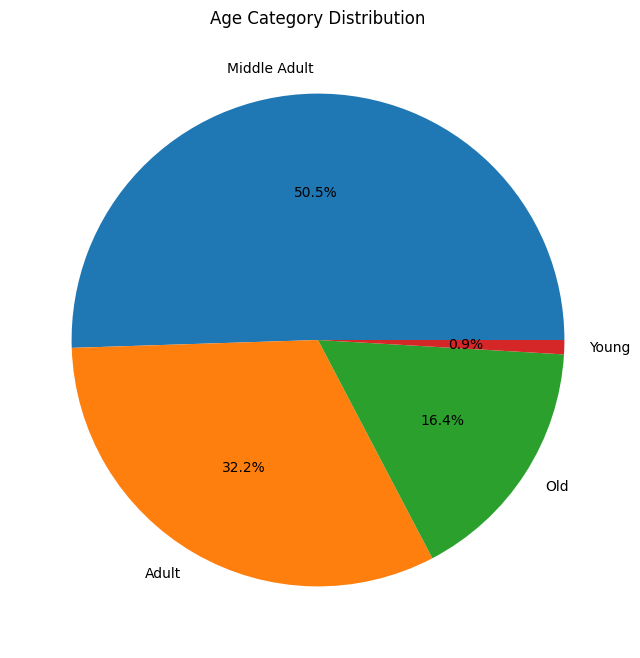

In [19]:
age_distribution = df_Total['age_category'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
age_distribution.plot(kind='pie', autopct='%1.1f%%')

plt.title('Age Category Distribution')
plt.ylabel('')  # Hide the y-label as it's a pie chart

# Display the plot
plt.show()

In [20]:
# high level gender break down 

gender_counts = df_Total['gendr'].value_counts()

In [21]:
# gender break down focused on Middle adult category ( 50% of age_category)

df_Total[df_Total['age_category'] == 'Middle Adult']['gendr'].value_counts()

gendr
Female        58364
Male          57332
Unknown       46591
Non-binary        5
Name: count, dtype: int64

In [22]:
df_Total[df_Total['age_category'] == 'Middle Adult']['gendr'].value_counts(normalize = True)*100

gendr
Female        35.962339
Male          35.326449
Unknown       28.708131
Non-binary     0.003081
Name: proportion, dtype: float64

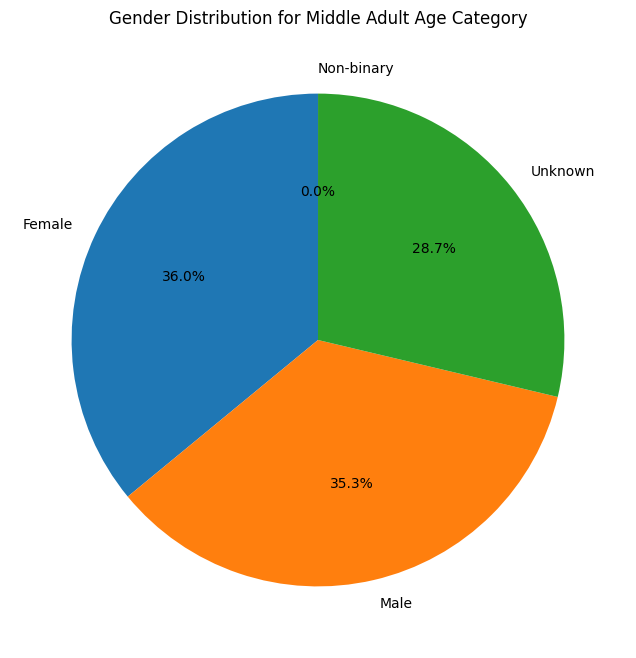

In [23]:

# Filter the DataFrame for 'Middle Adult' age category
middle_adult_gender_distribution = df_Total[df_Total['age_category'] == 'Middle Adult']['gendr'].value_counts(normalize=True) * 100

# Creating the pie chart
plt.figure(figsize=(8, 8))
middle_adult_gender_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90)

plt.title('Gender Distribution for Middle Adult Age Category')
plt.ylabel('')  # Hide y-label for clarity in pie chart
plt.show()

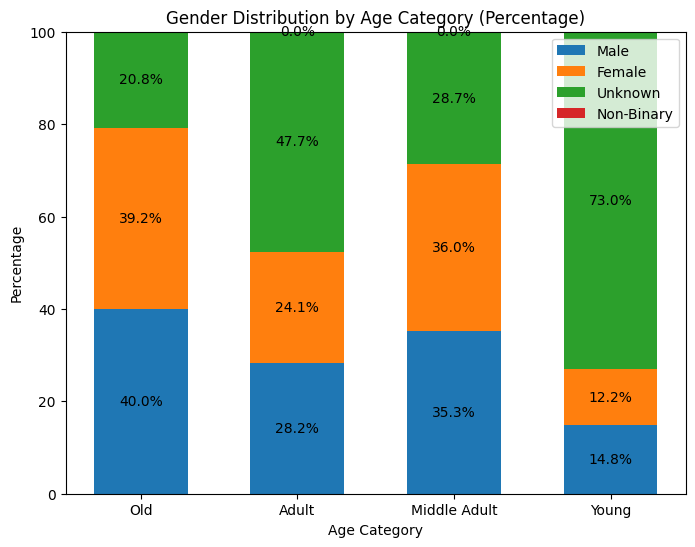

In [24]:

# Bar chart combining age_category and gender 



age_categories = df_Total['age_category'].unique()

# Calculate total counts for each age category
age_totals = np.array([df_Total[df_Total['age_category'] == age].shape[0] for age in age_categories])

# Calculate percentages for each gender
gender_percentages = {
    'Male': np.array([df_Total[(df_Total['age_category'] == age) & (df_Total['gendr'] == 'Male')].shape[0] / total * 100 for age, total in zip(age_categories, age_totals)]),
    'Female': np.array([df_Total[(df_Total['age_category'] == age) & (df_Total['gendr'] == 'Female')].shape[0] / total * 100 for age, total in zip(age_categories, age_totals)]),
    'Unknown': np.array([df_Total[(df_Total['age_category'] == age) & (df_Total['gendr'] == 'Unknown')].shape[0] / total * 100 for age, total in zip(age_categories, age_totals)]),
    'Non-Binary': np.array([df_Total[(df_Total['age_category'] == age) & (df_Total['gendr'] == 'Non-binary')].shape[0] / total * 100 for age, total in zip(age_categories, age_totals)])
}

width = 0.6  # width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bottom = np.zeros(len(age_categories))

for gender, percentages in gender_percentages.items():
    p = ax.bar(age_categories, percentages, width, label=gender, bottom=bottom)
    bottom += percentages
    ax.bar_label(p, label_type='center', fmt='%.1f%%')  # Display as percentage

ax.set_xlabel('Age Category')
ax.set_ylabel('Percentage')
ax.set_title('Gender Distribution by Age Category (Percentage)')
ax.legend()

plt.show()

In [25]:
# frequency of gender fem vs mal




# Assuming 'gender', 'logons_6_mnth', and 'visit_id' are column names in your DataFrame

# Calculate the mean logons for each gender
usage_by_gender = df_Total.groupby('gendr').agg({
    'logons_6_mnth': 'mean',  # Average logons in the last 6 months
    #'visit_id': 'mean'  # Uncomment if you have visit ID counts
})

print(usage_by_gender)

            logons_6_mnth
gendr                    
Female           6.013221
Male             6.617009
Non-binary       7.125000
Unknown          6.180959


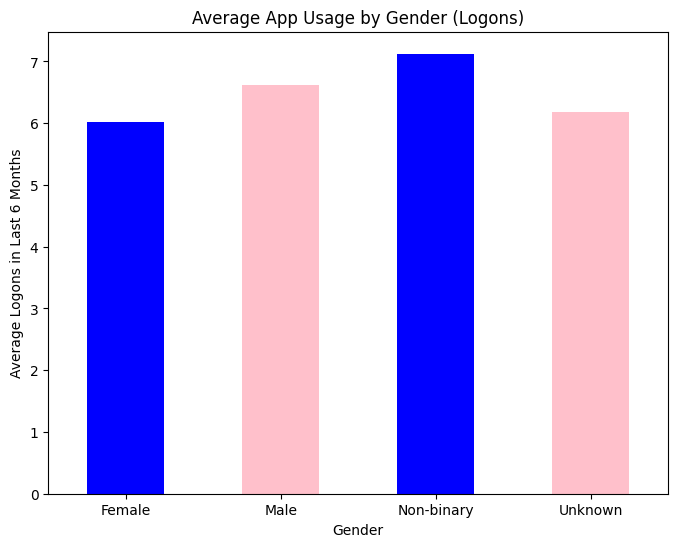

In [26]:
import matplotlib.pyplot as plt

# Plotting
usage_by_gender['logons_6_mnth'].plot(kind='bar', figsize=(8, 6), color=['blue', 'pink'])

plt.title('Average App Usage by Gender (Logons)')
plt.xlabel('Gender')
plt.ylabel('Average Logons in Last 6 Months')
plt.xticks(rotation=0)
plt.show()

## KPIs analysis 


**Engagement metric**

- Measure user engagement through calls_6_mnth and logons_6_mnth to see if the new design encourages more interactions or communication.
- calls_6_mnth: Records the number of times the client reached out over a call in the past six months.
- logons_6_mnth: Reflects the frequency with which the client logged onto Vanguard’s platform over the last six months.




In [27]:
#Engagement KPI based on critical steps Test vs Control 


# Group by variation and process step, aggregating by client_id
engagement_summary = df_Total.groupby(['variation', 'process_step'], as_index=False).agg({
    'client_id': pd.Series.nunique # Counting unique clients
})


In [28]:
print(engagement_summary)

  variation process_step  client_id
0   Control      confirm      15434
1   Control        start      23397
2   Control       step_1      20152
3   Control       step_2      18650
4   Control       step_3      17422
5      Test      confirm      18687
6      Test        start      26679
7      Test       step_1      24267
8      Test       step_2      22258
9      Test       step_3      20881


In [29]:
for variation in engagement_summary['variation'].unique():
    print(f"\nEngagement summary for {variation} group:")
    subset = engagement_summary[engagement_summary['variation'] == variation]
    for _, row in subset.iterrows():
        print(f"  {row['process_step']}: {row['client_id']} unique clients engaged")


Engagement summary for Control group:
  confirm: 15434 unique clients engaged
  start: 23397 unique clients engaged
  step_1: 20152 unique clients engaged
  step_2: 18650 unique clients engaged
  step_3: 17422 unique clients engaged

Engagement summary for Test group:
  confirm: 18687 unique clients engaged
  start: 26679 unique clients engaged
  step_1: 24267 unique clients engaged
  step_2: 22258 unique clients engaged
  step_3: 20881 unique clients engaged


**Overall Participation: The test group shows higher engagement across all steps than the control group. This likely indicates that the changes introduced in the test variant positively influenced user engagement**

**The "confirm" step at the end reflects higher engagement in the test group, suggesting that more users complete the entire process in the test variant compared to the control variant**


In [30]:
# Group by 'variation' and 'process_step', and aggregate the calls and logons

engagement_summary3 = df_Total.groupby(['variation', 'process_step']).agg({
    'calls_6_mnth': 'mean',  # Use 'sum' for total, 'mean' gives average per user
    'logons_6_mnth': 'mean'
})

In [31]:
print(engagement_summary3)


                        calls_6_mnth  logons_6_mnth
variation process_step                             
Control   confirm           3.224793       6.262496
          start             3.380482       6.413922
          step_1            3.292335       6.326985
          step_2            3.189446       6.225218
          step_3            3.167317       6.202544
Test      confirm           3.310163       6.345191
          start             3.255498       6.293392
          step_1            3.163640       6.204060
          step_2            3.141340       6.183581
          step_3            3.123774       6.164440


In [32]:
engagement_summary2 = df_Total.groupby(['variation']).agg({
    'calls_6_mnth': 'mean',  # Use 'sum' for total, 'mean' gives average per user
    'logons_6_mnth': 'mean'
})

print(engagement_summary2)

           calls_6_mnth  logons_6_mnth
variation                             
Control        3.274916       6.309831
Test           3.204310       6.243501


**Conclusion: High level the mean of call and logons in Test vs Control decreased. I assume the new design is more intuitive, users might find it easier to navigate and complete tasks without needing as much support or multiple logins**

**Retention Rate metric**
- A/B testing: we identify which version encourages users to return and engage more.

In [33]:
# Fix time period set up: start date vs last visit date

df_Total['date_time'].dtype

dtype('O')

In [34]:

df_Total['date_time'] = pd.to_datetime(df_Total['date_time'])  # Convert to datetime
df_Total['visit_date'] = df_Total['date_time'].dt.date  # Extract the date part


print(df_Total['visit_date'])

0         2017-04-17
1         2017-04-17
2         2017-04-17
3         2017-04-17
4         2017-04-17
             ...    
321304    2017-05-06
321305    2017-05-10
321306    2017-05-10
321307    2017-05-10
321308    2017-05-10
Name: visit_date, Length: 321309, dtype: object


In [35]:
cohort_period_start = pd.to_datetime('2017-04-17')
cohort_period_end = pd.to_datetime('2017-05-10')
assessment_period_end = pd.to_datetime('2017-05-31')  # personal assumption

In [36]:
results = []

for variation in df_Total['variation'].unique():
    # Filter for initial cohort visits only
    initial_cohort = df_Total[(df_Total['variation'] == variation) &
                              (df_Total['date_time'] >= cohort_period_start) &
                              (df_Total['date_time'] <= cohort_period_end)]
    
    total_visitors = initial_cohort['client_id'].nunique()

    # Filter for return users (after initial visit and before assessment period end)
    subsequent_visits = df_Total[(df_Total['client_id'].isin(initial_cohort['client_id'])) &
                                 (df_Total['date_time'] > cohort_period_end) &
                                 (df_Total['date_time'] <= assessment_period_end)]
    
    returning_users = subsequent_visits['client_id'].nunique()

    retention_rate = (returning_users / total_visitors * 100) if total_visitors > 0 else 0
    results.append((variation, retention_rate))

for variation, rate in results:
    print(f"Retention Rate for {variation}: {rate:.2f}%")

Retention Rate for Test: 6.94%
Retention Rate for Control: 8.24%


**Conclusion: both engagement and retention rate in Test decreased vs Control variation in a time frame of 1 month**

# KPI Time Spent on Each Step: The average duration users spend on each step.¶

In [37]:

# Convert to datetime
#df_Total["date_time"] = pd.to_datetime(df_Total["date_time"])

# Sort to ensure correct step order
#df_Total = df_Total.sort_values(["client_id", "visit_id", "date_time"])

# Calculate time to next step within each session
#df_Total["next_time"] = df_Total.groupby(["client_id", "visit_id"])["date_time"].shift(-1)

# Duration in seconds spent on each step
#df_Total["time_spent_min"] = (df_Total["next_time"] - df_Total["date_time"]).dt.total_seconds()/60

# Compute average time per step
#time_by_step_variation = (
    df_Total.dropna(subset=["time_spent_min"])
      .groupby(["variation", "process_step"])["time_spent_min"]
      .mean()
      .unstack()
)

#print(time_by_step_variation)

IndentationError: unexpected indent (3178039675.py, line 15)

In [ ]:
#time_sum_by_variation = (
    #df_Total.dropna(subset=["time_spent_min"])
      .#groupby("variation")["time_spent_min"]
      .#sum()
      .#reset_index()
)

#print(time_sum_by_variation)

**Conclusion**
Control is Faster: The total time spent on the "Control" variation is significantly less compared to the "Test" variation. Especially in Step 1 & Confirm --> need to assess any bottlenects in Test phase.



## Hypothesis contradiction:
- The reduction in calls and logons for the test group is due to increased efficiency, and task completion time is shorter --> FALSE

In [ ]:
## KPI ERROR RATE%

step_order = [
    "start",
    "personal_info",
    "financial_info",
    "review",
    "confirm"
]

step_to_index = {step: idx for idx, step in enumerate(step_order)}

df_Total = df_Total[df_Total["process_step"].isin(step_order)].copy()

df_Total["step_index"] = df_Total["process_step"].map(step_to_index)

df_Total["prev_step_index"] = df_Total.groupby(
    ["client_id", "visit_id"]
)["step_index"].shift(1)

df_Total["is_error"] = df_Total["step_index"] < df_Total["prev_step_index"]

error_rate = (
    df_Total.groupby(["client_id", "visit_id"])["is_error"]
       .any()
       .mean()
)

print(f"Overall Error Rate: {error_rate:.2%}")

In [ ]:
session_errors = (
    df_Total
    .groupby(["client_id", "visit_id", "variation"])["is_error"]
    .any()
    .reset_index(name="session_error")
)

error_rate_by_variation = (
    session_errors
    .groupby("variation")["session_error"]
    .mean()
)

print(error_rate_by_variation)

**Conclusion**: error rate 1.5% in Control vs 0.6% in Test. Test is more efficient

# Hypothesis 1: testing to check with Ignacio

- Null Hypothesis (H0): There is no relationship between engagement (measured via retention rate and engagement rate) and efficiency (measured by time spent on steps).
- Alternative Hypothesis (H1): There is a relationship between engagement and efficiency.
-  Compute Pearson correlation
correlation_coefficient, p_value = pearsonr(engagement_metric, efficiency_metric)



In [ ]:
#combine the data into a single new df

combined_data = engagement_summary2.join(time_by_step_variation, on='variation')

In [ ]:
from scipy.stats import pearsonr, spearmanr

# Hypothesis 2
- Null Hypothesis (H0): There is  significant difference in retention rates between the Test and Control groups.
- Alternative Hypothesis (H1): There is not significant difference in retention rates between the Test and Control groups.

In [ ]:
#comparing proportions (retention rates) between two independent groups --> proportion z-test 



test_group = df_Total[df_Total['variation'] == 'Test']
control_group = df_Total[df_Total['variation'] == 'Control']

# Count unique users in each group
n_test = test_group['client_id'].nunique()
n_control = control_group['client_id'].nunique()

print(f"Number of users in Test group: {n_test}")
print(f"Number of users in Control group: {n_control}")


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Converting percentages to proportions
p_test = 0.0694
p_control = 0.0824

# Sample sizes
n_test = 26954  # actual test group size
n_control = 23513  

# Number of successes in each sample
successes = [p_test * n_test, p_control * n_control]
nobs = [n_test, n_control]

z_stat, p_value = proportions_ztest(successes, nobs)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: significant difference in retention rates.")
else:
    print("Fail to reject the null hypothesis: no significant difference in retention rates.")

# Hypothesis 3

-Null Hypothesis (H0): There is no significant difference in engagement rates between the Test and Control groups.
-Alternative Hypothesis (H1): There is a significant difference in engagement rates between the Test and Control groups.

In [38]:
#  standard deviation
engagement_std = df_Total.groupby('variation').agg({
    'calls_6_mnth': 'std',
    'logons_6_mnth': 'std'
})

print(engagement_std)

           calls_6_mnth  logons_6_mnth
variation                             
Control        2.184212       2.172911
Test           2.201479       2.189293


In [39]:
# t-test comparing the metrics for calls and logins between your test and control groups,

# Separate the data for test and control groups
control_calls = df_Total[df_Total['variation'] == 'control']['calls_6_mnth']
test_calls = df_Total[df_Total['variation'] == 'test']['calls_6_mnth']

control_logons = df_Total[df_Total['variation'] == 'control']['logons_6_mnth']
test_logons = df_Total[df_Total['variation'] == 'test']['logons_6_mnth']


In [40]:
df_Total['variation'].value_counts()

variation
Test       177847
Control    143462
Name: count, dtype: int64

In [41]:
df_Total['variation'].dtype

dtype('O')

In [42]:
df_Total.columns

Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'variation', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'tenure_group',
       'age_category', 'visit_date'],
      dtype='object')

In [43]:
df_Total[['calls_6_mnth', 'logons_6_mnth']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321309 entries, 0 to 321308
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   calls_6_mnth   321309 non-null  int64
 1   logons_6_mnth  321309 non-null  int64
dtypes: int64(2)
memory usage: 4.9 MB


In [44]:
control_calls = df_Total.loc[
    df_Total['variation'] == 'control', 'calls_6_mnth'
]
test_calls = df_Total.loc[
    df_Total['variation'] == 'test', 'calls_6_mnth'
]
control_logons = df_Total.loc[
    df_Total['variation'] == 'control', 'logons_6_mnth'
]
test_logons = df_Total.loc[
    df_Total['variation'] == 'test', 'logons_6_mnth'
]
print(len(control_calls), len(test_calls))
print(len(control_logons), len(test_logons))


0 0
0 0


In [45]:
from scipy.stats import ttest_ind
t_calls, p_calls = ttest_ind(
    control_calls, test_calls, equal_var=False
)
t_logons, p_logons = ttest_ind(
    control_logons, test_logons, equal_var=False
)
print(f"Calls → t-stat: {t_calls:.4f}, p-value: {p_calls:.6f}")
print(f"Logons → t-stat: {t_logons:.4f}, p-value: {p_logons:.6f}")


# t-stat is 5.7 there is a statistical different between the efficiency in test vs control both for calls and log ins. 
# there is a statistical different of 5% between test vs control --> valid to propose
# reason wether the sample size is too short for this type of UX test.


Calls → t-stat: nan, p-value: nan
Logons → t-stat: nan, p-value: nan


/Users/chiara/Ironhack/week5/project/week5_project_ab_testing/.venv/lib/python3.13/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [ ]:
df_Total['client_id'].nunique()

# Troubleshooting:

In [ ]:
# Check for NaN values in your datasets
print("NaNs in control_calls:", control_calls.isna().sum())
print("NaNs in test_calls:", test_calls.isna().sum())
print("NaNs in control_logons:", control_logons.isna().sum())
print("NaNs in test_logons:", test_logons.isna().sum())

In [ ]:
print("Unique variations in dataset:", df_Total['variation'].unique())

In [ ]:
# Strip whitespace and convert to lower case
df_Total['variation'] = df_Total['variation'].str.strip().str.lower()

In [ ]:
# Ensure that data loading is accurate
print(df_Total.head())

# Hypothesis 4: 
- completion time test vs control
-determine significant differences in completion times between your test and control groups across different process steps

In [ ]:
# Confirm data validity
print(df_Total[['variation', 'process_step', 'time_spent_min']].head())

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Function to interpret p-values
def interpret_p_value(p_value, alpha=0.05):
    return "Significant difference" if p_value < alpha else "No significant difference"

# Loop over each process step to perform ANOVA
for step in df_Total['process_step'].unique():
    # Filter data for the current step
    step_data = df_Total[df_Total['process_step'] == step]
    
    # Fit the OLS model; C(variation) indicates we're using 'variation' as a categorical variable
    model = ols('time_spent_min ~ C(variation)', data=step_data).fit()
    
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table["PR(>F)"]["C(variation)"]
    
    # Print results
    print(f"Process step '{step}':")
    print(anova_table)
    print(f"Interpretation: {interpret_p_value(p_value)}")
    print("-" * 50, "\n")

**Conclusion**
- start is not statistically different as p value > 0.05
- confirm is statistically different showung a difference in test vs control ( p value < 0.05)

In [ ]:
df_Total.to_csv("df_Total.csv", index=False)

In [ ]:
df_Total.columns

In [ ]:
df_Total['process_step'].nunique

In [ ]:
df_Total['date_time'].isna().value_counts

In [ ]:
df_Total['variation'].isna().value_counts

In [ ]:
df_Total['client_id'].value_counts()